## Figure_QC_metrics: 

This notebook is to generate plots/figures for the QC metrics from the multiome sequencing.
Some example metrics are:
- number of UMIs/cell
- number of genes/cell
- % mitochondrial reads/cell
- grouped.by datasets (or timepoints)

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number
mpl.rcParams['pdf.fonttype'] = 42
sns.set(style='whitegrid', context='paper')

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [3]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/QC_metrics/"
os.makedirs(figpath, exist_ok=True)
sc.settings.figdir = figpath

In [4]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA_formatted_excxg_zscape_labels.h5ad")
adata

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape'
    var: 'features'
    uns: 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

## step 0. compute the RNA QC metrics

In [54]:
adata.var_names

Index(['ptpn12', 'phtf2', 'phtf2.1', 'CU856344.1', 'si:zfos-932h1.3', 'mansc1',
       'lrp6', 'dusp16', 'crebl2', 'gpr19',
       ...
       'mt-nd4', 'NC-002333.16', 'NC-002333.15', 'NC-002333.8', 'mt-nd5',
       'mt-nd6', 'NC-002333.21', 'mt-cyb', 'NC-002333.22', 'NC-002333.11'],
      dtype='object', length=32057)

In [55]:
adata.var_names[adata.var_names.str.startswith("rps")]

Index(['rps16', 'rps13', 'rps4x', 'rps17', 'rps20', 'rps6ka3a', 'rps6ka4',
       'rps2', 'rps15a', 'rps11', 'rps19bp1', 'rps27a', 'rpsa', 'rps26l',
       'rps10', 'rps28', 'rps8a', 'rps3a', 'rps6', 'rps27.2', 'rps19', 'rps9',
       'rps6kc1', 'rps7', 'rps29', 'rps8b', 'rps6ka1', 'rps6ka5', 'rps6kl1',
       'rps6kal', 'rps6ka2', 'rps24', 'rps3', 'rps27.1', 'rps18', 'rps6kb1b',
       'rps5', 'rps21', 'rps26', 'rps12', 'rps14', 'rps15', 'rps23',
       'rps6kb1a', 'rps25', 'rps6ka3b', 'rps27l'],
      dtype='object')

In [56]:
# compute the QC metrics (scanpy)
adata.X = adata.layers["counts"].copy()

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("mt")
adata.var["nc"] = adata.var_names.str.startswith("nc")
adata.var["ribo"] = adata.var_names.str.startswith("rps")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt","nc","ribo"], 
                           percent_top=None, log1p=False, inplace=True)

### import the annotation

In [5]:
annotation = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/annotations/annotation_ML_06052024.txt", index_col=0, sep="\t")
annotation

,annotation_ML_v4
AAACAGCCACCTAAGC-1_1,epidermis
AAACAGCCAGGGAGGA-1_1,pronephros
AAACAGCCATAGACCC-1_1,hindbrain
AAACATGCAAACTCAT-1_1,spinal_cord
AAACATGCAAGGACCA-1_1,neural_optic2
...,...
TTTGTGTTCCCTCAGT-1_7,tail_bud
TTTGTTGGTACCTTAC-1_7,lateral_plate_mesoderm
TTTGTTGGTATTGAGT-1_7,neural_posterior
TTTGTTGGTGCGCGTA-1_7,endocrine_pancreas


In [6]:
adata.obs["annotation_ML"] = annotation["annotation_ML_v4"]
adata.obs["annotation_ML"]

AAACAGCCACCTAAGC-1_1                 epidermis
AAACAGCCAGGGAGGA-1_1                pronephros
AAACAGCCATAGACCC-1_1                 hindbrain
AAACATGCAAACTCAT-1_1               spinal_cord
AAACATGCAAGGACCA-1_1             neural_optic2
                                 ...          
TTTGTGTTCCCTCAGT-1_7                  tail_bud
TTTGTTGGTACCTTAC-1_7    lateral_plate_mesoderm
TTTGTTGGTATTGAGT-1_7          neural_posterior
TTTGTTGGTGCGCGTA-1_7        endocrine_pancreas
TTTGTTGGTTAAGGCC-1_7                   somites
Name: annotation_ML, Length: 95196, dtype: object

In [7]:
adata.obs.annotation_ML.unique()

array(['epidermis', 'pronephros', 'hindbrain', 'spinal_cord',
       'neural_optic2', 'neural_floor_plate', 'neural_crest2', 'PSM',
       'optic_cup', 'lateral_plate_mesoderm',
       'midbrain_hindbrain_boundary2', 'neural_telencephalon',
       'differentiating_neurons', 'muscle', 'fast_muscle',
       'low_quality_cells', 'heart_myocardium', 'somites', 'NMPs',
       'epidermis2', 'pharyngeal_arches', 'floor_plate2',
       'hemangioblasts', 'neural_posterior', 'floor_plate', 'tail_bud',
       'endoderm', 'midbrain_hindbrain_boundary', 'neural_crest',
       'neural_optic', 'hematopoietic_vasculature', 'endocrine_pancreas',
       'hatching_gland', 'neurons', 'notochord', 'pronephros2',
       'enteric_neurons', 'epidermis3', 'epidermis4', 'neural',
       'primordial_germ_cells'], dtype=object)

In [57]:
# filter out the low quality cells (annotated as either "nan" or "low_quality_cells")
multiome = adata[adata.obs.annotation_ML!="low_quality_cells"]
multiome

View of AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'features', 'mt', 'nc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    

## Step 1. generate RNA QC plots (grouped by timepoints/datasets)

In [66]:
df = multiome.obs

# Custom order for the x-axis
custom_order = ['TDR126', 'TDR127', 'TDR128', 'TDR118', 'TDR119', 'TDR125', 'TDR124']


In [49]:
df.columns

Index(['orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk',
       'nCount_peaks_celltype', 'nFeature_peaks_celltype',
       'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight',
       'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity',
       'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset',
       'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8',
       'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape',
       'annotation_ML_coarse'],
      dtype='object')

/tmp/ipykernel_1788964/3413688409.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 6)  # Get 6 colors from the viridis colormap
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bootstrap=bootstrap))


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'TDR126'),
  Text(1, 0, 'TDR127'),
  Text(2, 0, 'TDR128'),
  Text(3, 0, 'TDR118'),
  Text(4, 0, 'TDR119'),
  Text(5, 0, 'TDR125'),
  Text(6, 0, 'TDR124')])

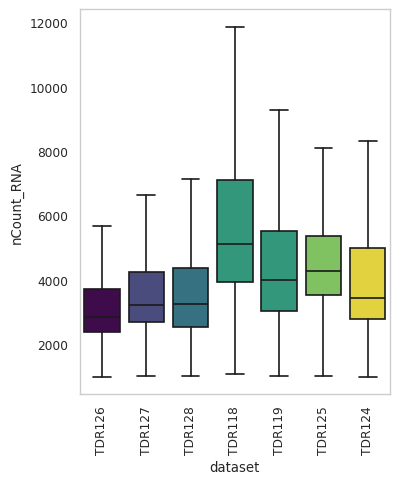

In [68]:
# Custom order for the x-axis
custom_order = ['TDR126', 'TDR127', 'TDR128', 'TDR118', 'TDR119', 'TDR125', 'TDR124']

# Generate colors using the viridis colormap
viridis = plt.cm.get_cmap('viridis', 6)  # Get 6 colors from the viridis colormap

# Assign colors to the datasets, with TDR118 and TDR119 sharing the same color
custom_colors = [viridis(0), viridis(1), viridis(2), viridis(3), viridis(3), viridis(4), viridis(5)]

# Set up the plot
plt.figure(figsize=(4, 5))

ax = sns.boxplot(data=df, x="dataset", y="nCount_RNA", palette=custom_colors, order=custom_order, showfliers=False)
ax.grid(False)
plt.xticks(rotation=90)


/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bootstrap=bootstrap))
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bootstrap=bootstrap))
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

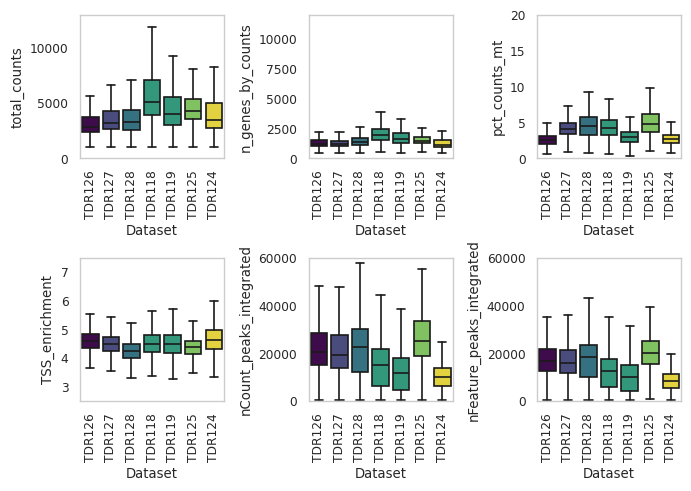

In [90]:
# Set up the subplots
fig, axes = plt.subplots(2, 3, figsize=(7, 5), sharey=False)

# List of columns to plot
columns_to_plot = ["total_counts","n_genes_by_counts",
                   "pct_counts_mt",#"pct_counts_ribo",
                   "TSS_enrichment","nCount_peaks_integrated", "nFeature_peaks_integrated"]

# Titles for the subplots
#titles = ["Number of Features (RNA)", "Number of Peaks Integrated", "Number of Features Peaks Integrated"]

# Y-axis limits for each subplot
y_limits = [(0, 13000), (0, 12000), (0, 20), 
            (2.5, 7.5), (0, 60000), (0, 60000)]  # Adjust these limits based on your data

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and create a boxplot for each
for ax, column, y_lim in zip(axes, columns_to_plot, y_limits):
    sns.boxplot(data=df, x="dataset", y=column, palette=custom_colors, order=custom_order, showfliers=False, ax=ax)
    # ax.set_title(title)
    ax.set_xlabel('Dataset')
    ax.set_ylabel(column)
    ax.set_ylim(y_lim)  # Set y-axis limits
    ax.grid(False)
    # ax.axhline(y=500, color='r', linestyle='--')  # Add a horizontal line at y=500

# Rotate x-axis labels
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Adjust layout
plt.tight_layout()

plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/QC_metrics/QC_metrics_RNA_ATAC.pdf")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/QC_metrics/QC_metrics_RNA_ATAC.png")


# Show the plot
plt.show()